In [ ]:
%pip install pandas seaborn geopandas bokeh jupyter_bokeh

### Choropleth Map of Biodiversity - State

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from bokeh.palettes import Blues256
from bokeh.io import output_notebook
from bokeh.plotting import output_file, save, figure, show
from bokeh.layouts import layout
from bokeh.models import HoverTool, RangeSlider, CustomJS, RadioButtonGroup
from bokeh.models import GeoJSONDataSource
from bokeh.models import LinearColorMapper, ColorBar

Using the Simpson Diversity Index formula where 0 represents no diversity and 1 represents infinite diversity:

$D = 1 - \sum^R_{i=1} (\dfrac {n_i(n_i-1)}{N(N-1)})$

Formula sourced from: [Libretexts](https://stats.libretexts.org/Bookshelves/Applied_Statistics/Natural_Resources_Biometrics_(Kiernan)/10%3A_Quantitative_Measures_of_Diversity_Site_Similarity_and_Habitat_Suitability/10.01%3A_Introduction__Simpsons_Index_and_Shannon-Weiner_Index#title)

In [3]:
def simpson_diversity(df: pd.DataFrame, spec_col: str, count_col: str) -> float:
  sum = 0
  total_individuals = df[count_col].sum()

  if total_individuals == 1:
    return 0 # Only one species exists, no diversity

  for _, species, count in df.itertuples():
    sum += ((count) * (count - 1)) / (total_individuals * (total_individuals - 1))

  return 1 - sum

Using the Shannon-Wiener Diversity Index

$H' = \frac {N ln \ N -\sum (n_i ln \ n_i)}{N}$

Formula sourced from: [Libretexts](https://stats.libretexts.org/Bookshelves/Applied_Statistics/Natural_Resources_Biometrics_(Kiernan)/10%3A_Quantitative_Measures_of_Diversity_Site_Similarity_and_Habitat_Suitability/10.01%3A_Introduction__Simpsons_Index_and_Shannon-Weiner_Index#title)

In [4]:
def shannon_diversity(df: pd.DataFrame, spec_col: str, count_col: str) -> float:
  sum = 0
  total_individuals = df[count_col].sum()
  for _, species, count in df.itertuples():
    sum += count * np.log(count)

  return ((total_individuals * np.log(total_individuals)) - (sum)) / total_individuals

Test Diversity Index functions

In [5]:
test_df = pd.DataFrame({
  'Species': ['Sugar Maple', 'Beech', 'Yellow Birch'],
  'No. of individuals': [35, 19, 11]
})

# This should output something close to 0.6053
print(simpson_diversity(test_df, 'Species', 'No. of individuals'))

# This should output soomething close to 0.993
print(shannon_diversity(test_df, 'Species', 'No. of individuals'))

0.6052884615384615
0.9934892582483463


<Axes: >

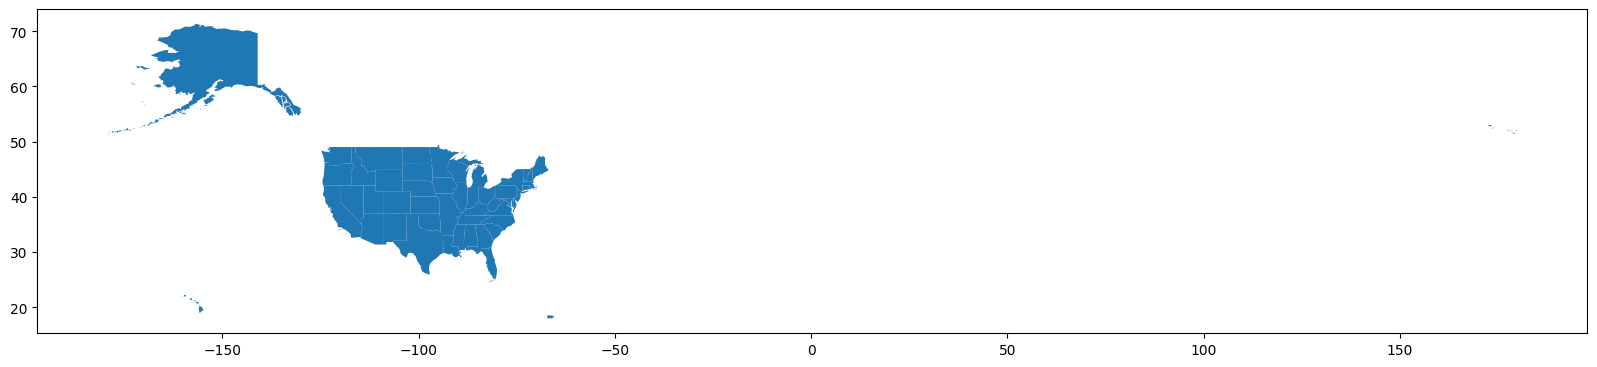

In [6]:
# Import occurrences shapefile

occurrence_gdf = gpd.read_file(Path('../output/occurrences/occurrences.shp'))

# Import USA state map
state_shp = gpd.read_file(Path('../dataset/cb_2023_us_all_20m/cb_2023_us_state_20m/cb_2023_us_state_20m.shp'))

# Update CRS of county map to match `occurrence_gdf`
state_shp = state_shp.to_crs(crs='EPSG:4326') 

state_shp.plot(figsize=(20,20))

<Axes: >

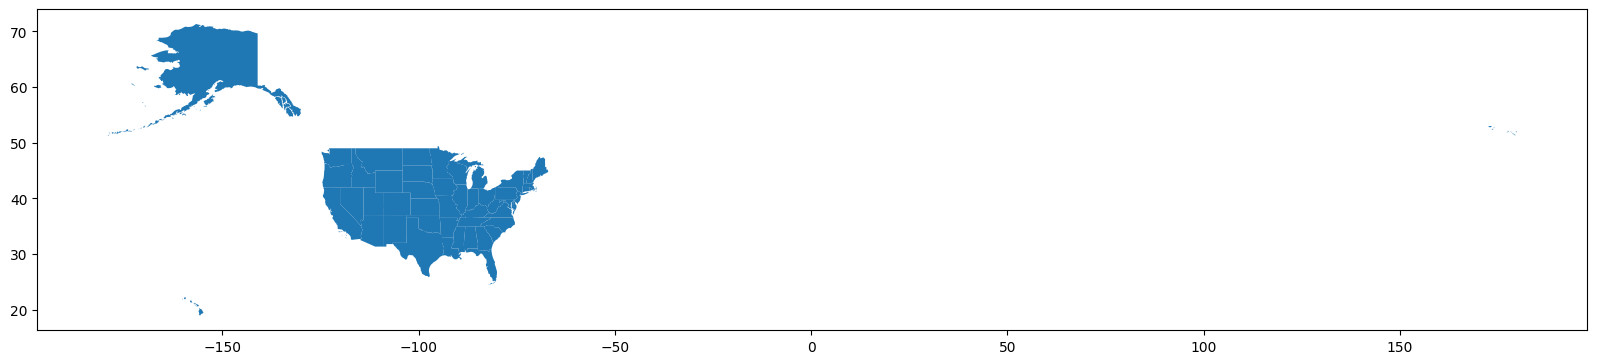

In [7]:
# Remove USA territories, get the 50 states

exclude = ['American Samoa', 'Commonwealth of the Northern Mariana Islands', 'Puerto Rico', 'United States Virgin Islands', 'Guam']

state_shp = state_shp[~state_shp['NAME'].isin(exclude)]

state_shp.plot(figsize=(20,20))

In [8]:
# Calculate the Simpson and Shannon-Wiener biodiversity for a given `year` for each given `plots` using an `occurrences` dataframe
def plot_biodiversity(plots: gpd.GeoDataFrame, occurrences: gpd.GeoDataFrame, year: int) -> gpd.GeoDataFrame:
  data = {
    f'{year}_simpson': [],
    f'{year}_shannon': []
  }

  year_occurrences = occurrences[occurrences['year'] == year]
  
  for row in plots.itertuples():
    county_occurrences = year_occurrences[row.geometry.contains(year_occurrences['geometry'])]
    if len(county_occurrences) == 0:
      data[f'{year}_simpson'].append(pd.NA)
      data[f'{year}_shannon'].append(pd.NA)
    else:
      data[f'{year}_simpson'].append(
        simpson_diversity(county_occurrences['verbatName'].value_counts().reset_index(), 'verbatName', 'count')
      )
      data[f'{year}_shannon'].append(
        shannon_diversity(county_occurrences['verbatName'].value_counts().reset_index(), 'verbatName', 'count')
      )

  plots[f'{year}_simpson'] = data[f'{year}_simpson']
  plots[f'{year}_shannon'] = data[f'{year}_shannon']

  return plots

In [9]:
# Produce a dataframe for the chart

chart_gdf = occurrence_gdf[occurrence_gdf['year'].notna()].copy()

chart_gdf['year'] = chart_gdf['year'].astype(int)

years = sorted(chart_gdf['year'].unique())

state_chart_gdf = state_shp.copy()

for year in years:
  state_chart_gdf = plot_biodiversity(state_chart_gdf, chart_gdf, year)

state_chart_gdf.head()

STATEFP   STATENS      GEOIDFQ GEOID STUSPS        NAME LSAD         ALAND  \
0      48  01779801  0400000US48    48     TX       Texas   00  676686238592   
1      06  01779778  0400000US06    06     CA  California   00  403673296401   
2      21  01779786  0400000US21    21     KY    Kentucky   00  102266598312   
3      13  01705317  0400000US13    13     GA     Georgia   00  149485311347   
4      55  01779806  0400000US55    55     WI   Wisconsin   00  140292627460   

        AWATER                                           geometry  ...  \
0  18982083586  POLYGON ((-106.62344 31.91403, -106.63011 31.9...  ...   
1  20291770234  MULTIPOLYGON (((-118.59397 33.4672, -118.48478...  ...   
2   2384223544  POLYGON ((-89.54443 36.57451, -89.47935 36.566...  ...   
3   4419673221  POLYGON ((-85.60516 34.98468, -85.47434 34.983...  ...   
4  29343084365  MULTIPOLYGON (((-86.93428 45.42115, -86.83575 ...  ...   

  2020_simpson 2020_shannon 2021_simpson 2021_shannon 2022_simpson  \
0         <NA>         <NA>         <NA>         <NA>         <NA>   
1         <NA>         <NA>         <NA>         <NA>         <NA>   
2         <NA>         <NA>         <NA>         <NA>         <NA>   
3     0.929419     3.240233     0.944046     3.190782     0.929198   
4         <NA>         <NA>         <NA>         <NA>         <NA>   

  2022_shannon 2023_simpson 2023_shannon 2024_simpson 2024_shannon  
0         <NA>     0.504274     1.069792         <NA>         <NA>  
1         <NA>         <NA>         <NA>         <NA>         <NA>  
2         <NA>         <NA>         <NA>         <NA>         <NA>  
3     2.793163         <NA>         <NA>         <NA>         <NA>  
4         <NA>         <NA>         <NA>         <NA>         <NA>  

[5 rows x 68 columns]

In [10]:
# Create default data for the first draw of the Bokeh plot

default_years = (2020, 2024)

filter_simpson_years = []
for year in range(default_years[0], default_years[1] + 1):
  if year in years:
    filter_simpson_years.append(f'{year}_simpson')

filter_shannon_years = []
for year in range(default_years[0], default_years[1] + 1):
  if year in years:
    filter_shannon_years.append(f'{year}_shannon')

state_chart_gdf['simpson_biodiversity'] = state_chart_gdf[filter_simpson_years].mean(axis=1)
state_chart_gdf['shannon_biodiversity'] = state_chart_gdf[filter_shannon_years].mean(axis=1)

state_chart_gdf.head(5)

STATEFP   STATENS      GEOIDFQ GEOID STUSPS        NAME LSAD         ALAND  \
0      48  01779801  0400000US48    48     TX       Texas   00  676686238592   
1      06  01779778  0400000US06    06     CA  California   00  403673296401   
2      21  01779786  0400000US21    21     KY    Kentucky   00  102266598312   
3      13  01705317  0400000US13    13     GA     Georgia   00  149485311347   
4      55  01779806  0400000US55    55     WI   Wisconsin   00  140292627460   

        AWATER                                           geometry  ...  \
0  18982083586  POLYGON ((-106.62344 31.91403, -106.63011 31.9...  ...   
1  20291770234  MULTIPOLYGON (((-118.59397 33.4672, -118.48478...  ...   
2   2384223544  POLYGON ((-89.54443 36.57451, -89.47935 36.566...  ...   
3   4419673221  POLYGON ((-85.60516 34.98468, -85.47434 34.983...  ...   
4  29343084365  MULTIPOLYGON (((-86.93428 45.42115, -86.83575 ...  ...   

  2021_simpson 2021_shannon 2022_simpson 2022_shannon 2023_simpson  \
0         <NA>         <NA>         <NA>         <NA>     0.504274   
1         <NA>         <NA>         <NA>         <NA>         <NA>   
2         <NA>         <NA>         <NA>         <NA>         <NA>   
3     0.944046     3.190782     0.929198     2.793163         <NA>   
4         <NA>         <NA>         <NA>         <NA>         <NA>   

  2023_shannon 2024_simpson 2024_shannon simpson_biodiversity  \
0     1.069792         <NA>         <NA>             0.504274   
1         <NA>         <NA>         <NA>                  NaN   
2         <NA>         <NA>         <NA>                  NaN   
3         <NA>         <NA>         <NA>             0.934221   
4         <NA>         <NA>         <NA>                  NaN   

  shannon_biodiversity  
0             1.069792  
1                  NaN  
2                  NaN  
3             3.074726  
4                  NaN  

[5 rows x 70 columns]

In [13]:
output_notebook()

Loading BokehJS ...

In [ ]:
# Reproject `state_chart_gdf` to use 360 degrees and disregard the antimeridian
# This prevents Alaska's Aleutian Islands from being cut off
state_chart_gdf = state_chart_gdf.to_crs({'init': 'epsg:4326', 'lon_wrap': 180})

In [20]:
# Create the Bokeh chart

from bokeh.layouts import layout

patch_colors = []
palette = list(reversed(Blues256)) # light for low values, dark for high values
for _, row in state_chart_gdf.iterrows():
    try:
        i = int(row['simpson_biodiversity'] * 255)
        patch_colors.append(palette[i])
    except ValueError: # Value is NaN
        patch_colors.append(palette[0])

### Uncomment to see Shannon-Wiener colors on the first draw
# shannon_max = state_chart_gdf['shannon_biodiversity'].max()
# for _, row in state_chart_gdf.iterrows():
#     try:
#         proportion = row['shannon_biodiversity'] / shannon_max
#         i = int(proportion * 7)
#         patch_colors.append(palette[i])
#     except ValueError: # Value is NaN
#         patch_colors.append(palette[0])

state_chart_gdf['color'] = patch_colors

source = GeoJSONDataSource(geojson=state_chart_gdf.to_json())

p = figure(
    title="Choropleth Map of USA Biodiversity by State",
    toolbar_location='left',
    width=800,
    height=800,
)

patches = p.patches('xs', 'ys', source=source, fill_color='color', fill_alpha=0.7, line_color = "black", line_width = 0.5)

color_mapper = LinearColorMapper(palette=list(reversed(Blues256)))
color_bar = ColorBar(
    color_mapper=color_mapper, 
    padding=5, 
    bar_line_color='black', 
    title='Increasing Biodiversity ------->',
)
p.add_layout(color_bar, 'right')

p.add_tools(HoverTool(tooltips=[
    ("State", "@NAME"),
    ("Simpson Index", "@simpson_biodiversity"),
    ("Shannon-Wiener Index", "@shannon_biodiversity"),
], point_policy="follow_mouse"))

range_js = """
    var data = source.data;
    var palette = palette;

    // cb_obj.value[0] // Start Year

    // cb_obj.value[1] // End Year

    var years = [];

    // Get valid years between the range values
    for (var i = 0; i <= cb_obj.value[1] - cb_obj.value[0]; i++) {
        let year = cb_obj.value[0] + i;

        // We only need to check this for one index
        if (`${year}_simpson` in data) {
            years.push(year);
        }
    }

    // Recalculate biodiversity (Get mean of all valid years)
    // Other indices have the same length as the array used here
    for (var i = 0; i < data.simpson_biodiversity.length; i++) {
        // Get average of values for this row
        let simpson = 0;
        let shannon = 0;

        let valid_simpson_count = 0;
        let valid_shannon_count = 0;

        for (var j = 0; j < years.length; j++) {
            let year = years[j];

            if (!isNaN(data[`${year}_simpson`][i])) {
                simpson += data[`${year}_simpson`][i];
                valid_simpson_count += 1;
            }
            if (!isNaN(data[`${year}_shannon`][i])) {
                shannon += data[`${year}_shannon`][i];
                valid_shannon_count += 1;
            }
        }

        data.simpson_biodiversity[i] = simpson / valid_simpson_count;
        data.shannon_biodiversity[i] = shannon / valid_shannon_count;
    }

    // Update patch colors

    // Simpson Index
    if (btn.active == 0) {
        // Update Colors

        for (var i = 0; i < data.color.length; i++) {
            if (isNaN(data.simpson_biodiversity[i])) {
                data.color[i] = palette[0];
            }
            else {
                data.color[i] = palette[Math.floor(data.simpson_biodiversity[i] * 255)];
            }
        }
    }

    // Shannon-Wiener Index
    if (btn.active == 1) {
        // Update Colors
        
        // Get max Shannon-Wiener Index value
        let shannon_max = 0

        for (var i = 0; i < data.shannon_biodiversity.length; i++) {
            if (!isNaN(data.shannon_biodiversity[i])) {
                if (data.shannon_biodiversity[i] > shannon_max) {
                    shannon_max = data.shannon_biodiversity[i]
                }
            }
        }
        
        for (var i = 0; i < data.color.length; i++) {
            if (isNaN(data.shannon_biodiversity[i])) {
                data.color[i] = palette[0];
            }
            else {
                let proportion = data.shannon_biodiversity[i] / shannon_max
                data.color[i] = palette[Math.floor(proportion * 255)];
            }
        }
    }

    source.change.emit();
"""

button_js = """
    var data = source.data;
    var palette = palette;

    // Simpson Index
    if (btn.active == 0) {
        // Update Colors

        for (var i = 0; i < data.color.length; i++) {
            if (isNaN(data.simpson_biodiversity[i])) {
                data.color[i] = palette[0];
            }
            else {
                data.color[i] = palette[Math.floor(data.simpson_biodiversity[i] * 255)];
            }
        }
    }

    // Shannon-Wiener Index
    if (btn.active == 1) {
        // Update Colors
        
        // Get max Shannon-Wiener Index value
        let shannon_max = 0

        for (var i = 0; i < data.shannon_biodiversity.length; i++) {
            if (!isNaN(data.shannon_biodiversity[i])) {
                if (data.shannon_biodiversity[i] > shannon_max) {
                    shannon_max = data.shannon_biodiversity[i]
                }
            }
        }
        
        for (var i = 0; i < data.color.length; i++) {
            if (isNaN(data.shannon_biodiversity[i])) {
                data.color[i] = palette[0];
            }
            else {
                let proportion = data.shannon_biodiversity[i] / shannon_max
                data.color[i] = palette[Math.floor(proportion * 255)];
            }
        }
    }

    source.change.emit();
"""

labels = ['Simpson Index', 'Shannon-Wiener Index']

radio_buttons = RadioButtonGroup(labels=labels, active=0)

range_slider = RangeSlider(title="Years", start=years[0], end=years[-1], value=default_years, step=1)

range_slider.js_on_change('value', CustomJS(args=dict(source=source, palette=palette, btn=radio_buttons), code = range_js))

radio_buttons.js_on_event("button_click", CustomJS(args=dict(source=source, palette=palette, btn=radio_buttons, renderer=p.renderers[0], patches=patches), code=button_js))

layout = layout(
    [range_slider, radio_buttons],
    [p]
)

show(layout)

In [ ]:
# Save plot to a file
output_file(filename=Path('../charts/biodiversity_state.html'), title='Choropleth Map of USA Biodiversity by State')
save(layout)